# FS2024: 21109 Privacy and Data Security - Exercise 07

## Differential Privacy – Practice

### Installing libraries

Before starting, make sure you have the necessary libraries installed. To install them, run the following command:

In [ ]:
!pip install -r requirements.txt

### Library Imports

In [2]:
import warnings
from sys import maxsize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from diffprivlib.accountant import BudgetAccountant
from diffprivlib.mechanisms import LaplaceTruncated
from diffprivlib.utils import PrivacyLeakWarning, warn_unused_args, check_random_state

### Custom Histogram Function using Laplace Mechanism

In [3]:
def laplaceHistogram(sample, epsilon=1.0, bins=10, range=None, weights=None, density=None, random_state=None, accountant=None,
              **unused_args):
    warn_unused_args(unused_args)

    random_state = check_random_state(random_state)

    accountant = BudgetAccountant.load_default(accountant)
    accountant.check(epsilon, 0)

    if range is None:
        warnings.warn("Range parameter has not been specified. Falling back to taking range from the data.\n"
                      "To ensure differential privacy, and no additional privacy leakage, the range must be "
                      "specified independently of the data (i.e., using domain knowledge).", PrivacyLeakWarning)

    hist, bin_edges = np.histogram(sample, bins=bins, range=range, weights=weights, density=None)

    dp_mech = LaplaceTruncated(epsilon=epsilon, sensitivity=1, lower=0, upper=maxsize, random_state=random_state)

    dp_hist = np.zeros_like(hist)

    for i in np.arange(dp_hist.shape[0]):
        dp_hist[i] = dp_mech.randomise(int(hist[i]))

    accountant.spend(epsilon, 0)

    if density:
        bin_sizes = np.array(np.diff(bin_edges), float)
        return dp_hist / bin_sizes / (dp_hist.sum() if dp_hist.sum() else 1), bin_edges

    return dp_hist, bin_edges

### Helper Functions

In [4]:
def getHist(data, epsilon, bins, range, random_state=None):
  hist, bins = np.histogram(data, bins=bins, range=range) if epsilon is None else laplaceHistogram(data, epsilon=epsilon, bins=bins, range=range, random_state=random_state)
  
  hist = hist / hist.sum()
  return hist, bins

def plotHistograms(data, title, epsilons, bins, range, xLabels=None, random_state=None):
  histArr = []
  binsArr = []

  for epsilon in epsilons:
    hist, bin = getHist(data, epsilon, bins, range, random_state=random_state)
    histArr.append(hist)
    binsArr.append(bin)

  maxY = max([max(hist) for hist in histArr])

  fig, axs = plt.subplots(len(epsilons) // 2 + len(epsilons) % 2, 2, figsize=(9, 9))

  for i in np.arange(len(epsilons)):
    ax = axs[i // 2, i % 2]
    ax.bar(binsArr[i][:-1], histArr[i], width=(binsArr[i][1]-binsArr[i][0]) * (0.9 if xLabels is None else 0.75))
    ax.set_title(f"Epsilon: {epsilons[i]}" if epsilons[i] is not None else "Without Differential Privacy")

    if xLabels is not None:
      ax.set_xticks(binsArr[i][:-1])
      ax.set_xticklabels(xLabels)
      ax.tick_params(axis='x', labelsize=8, rotation=90)
    else:
      ax.set_xticks(binsArr[i][:-1])
      ax.set_xticklabels([f"{int(binsArr[i][j]) + (1 if int(binsArr[i][j]) != 0 else 0)}-{int(binsArr[i][j+1])}"
                          for j in np.arange(len(binsArr[i]) - 1)])
      ax.tick_params(axis='x', labelsize=8, rotation=90)

    for j in np.arange(len(binsArr[i]) - 1):
      ax.text(binsArr[i][j], histArr[i][j] + 0.01, f"{histArr[i][j]:.2f}", ha='center', va='bottom', rotation=(90 if bins > 15 else 0))

    ax.set_ylim(0, maxY + 0.05)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    
  fig.suptitle(title, fontsize=16)

  plt.tight_layout()
  plt.show()

### Loading Data and Plotting Histograms

In [5]:
df = pd.read_csv('./data/ex05-fake-registration.csv')

epsilons = [None, 0.1, 0.5, 2]

#### a) Attribute: Ort

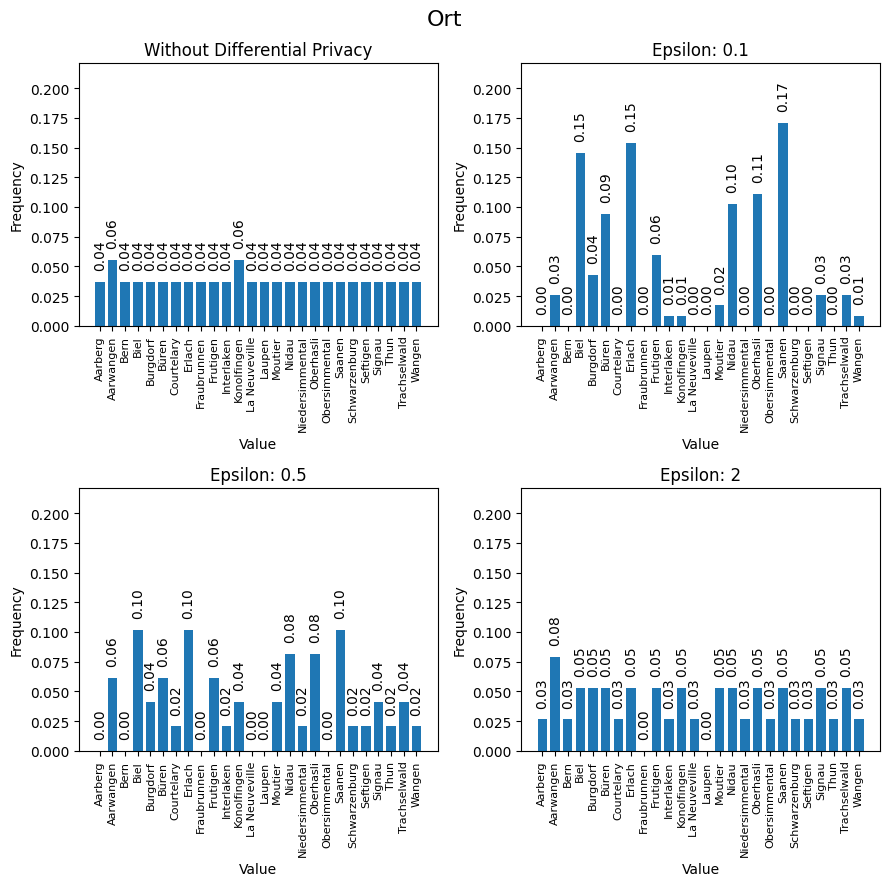

In [6]:
catOrt = pd.Categorical(df['Ort'].to_numpy())

ort = catOrt.codes
xLabels = catOrt.categories

plotHistograms(ort, "Ort", epsilons, len(xLabels), (ort.min(), ort.max()), xLabels=xLabels, random_state=42)

#### b) Attribute: System

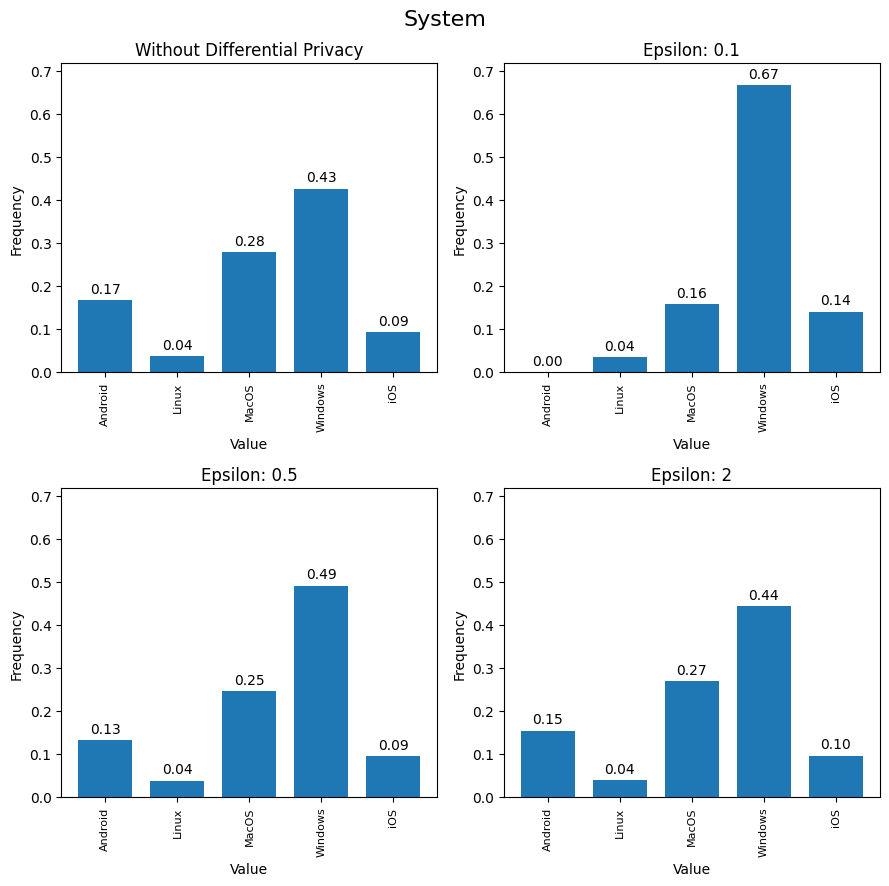

In [7]:
catSystem = pd.Categorical(df['System'].to_numpy())

system = catSystem.codes
xLabels = catSystem.categories

plotHistograms(system, "System", epsilons, len(xLabels), (system.min(), system.max()), xLabels=xLabels, random_state=42)

#### c) Attribute: Points

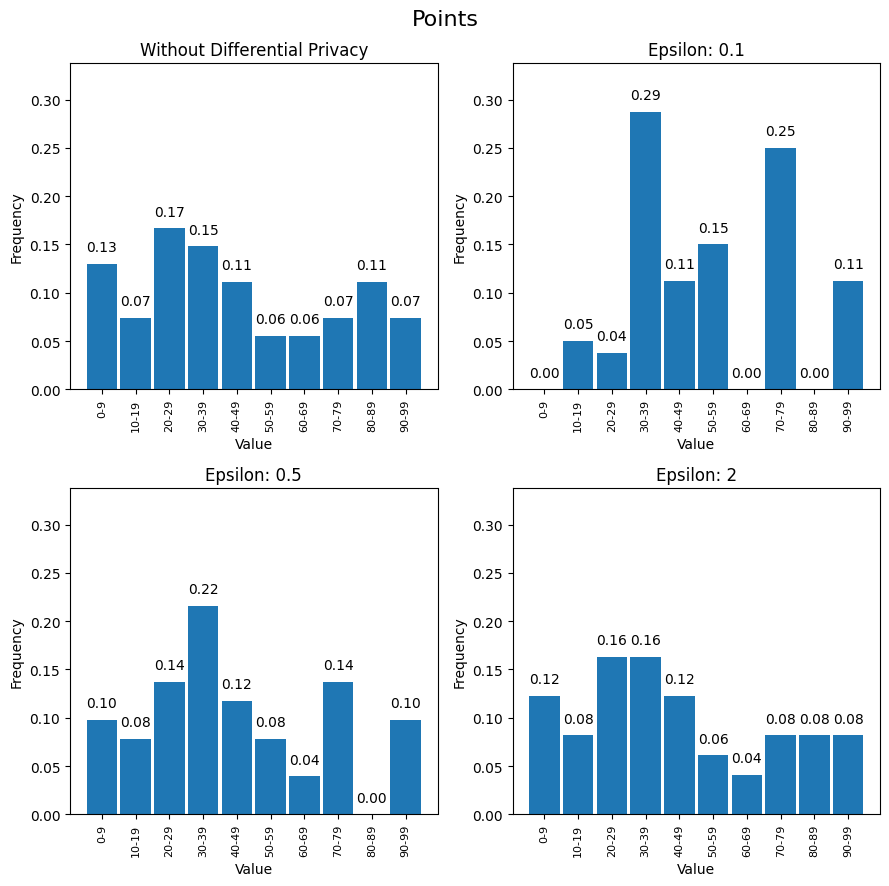

In [8]:
points = df['Points'].to_numpy()

plotHistograms(points, "Points", epsilons, 10, (0, 99), random_state=42)